# APS360 Group Project

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import matplotlib.pyplot as plt
import os

In [2]:
global device
print("Cuda Available:", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda Available: True


In [3]:
FONT_DATASET_PATH = "./fonts_image_dataset"
# Convert the images to tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Grayscale(num_output_channels=1)])
fonts_dataset = torchvision.datasets.ImageFolder(root = FONT_DATASET_PATH, transform=transform)
    
num_classes = len(fonts_dataset.classes)
    
# Create a list of indices for all the images in the dataset
dataset_size = len(fonts_dataset)
indices = list(range(dataset_size))
np.random.seed(0)
np.random.shuffle(indices)
# Split the indices into 60% Training 20% Validation 20% Testing. We need most of the data for training the network, but we must also set aside a bit for validation to fine tune the network, and test the network at the very end.
split1 = int(0.6 * dataset_size)
split2 = int(0.8 * dataset_size)
train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]
# Create a sampler for the training, validation, and testing sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

def load_dataset(dataset_path = FONT_DATASET_PATH, batch_size = 32):
    
    def custom_collate_fn(batch):
    
        # Use the default collate function to batch the data (images)
        batch = default_collate(batch)
        images, labels = batch
        
        # Apply one-hot encoding to the labels
        labels = F.one_hot(labels, num_classes=num_classes)

        return images, labels

    # Create the dataloaders for the training, validation, and testing sets
    train_loader = torch.utils.data.DataLoader(fonts_dataset, batch_size=batch_size,sampler=train_sampler,collate_fn=custom_collate_fn)
    val_loader = torch.utils.data.DataLoader(fonts_dataset, batch_size=batch_size,sampler=val_sampler,collate_fn=custom_collate_fn)
    test_loader = torch.utils.data.DataLoader(fonts_dataset, batch_size=batch_size,sampler=test_sampler,collate_fn=custom_collate_fn)

    print("Done Loading Data")

    return train_loader, val_loader, test_loader, fonts_dataset.classes


In [4]:
def total_error(outputs, labels):
    
    # Find the indices of the max values
    _, indices = torch.max(outputs, dim=1, keepdim=True)

    # Create a tensor of zeros with the same shape as x
    zeros = torch.zeros_like(outputs)

    # Set the max values to 1
    zeros.scatter_(1, indices, 1)
    
    return (zeros != labels).any(dim=1).float().sum()

def evaluate(net, loader, AE = False):

    net.eval()
    
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    
    if AE == True:
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
                
            # Forward pass
            outputs = net(inputs)
            
            # Calculate the statistics
            if AE == True:
                total_loss += criterion(outputs, inputs).item()
            else:  
                total_err += total_error(outputs, labels)
                total_loss += criterion(outputs, labels.float()).item()
            total_epoch += len(labels)

    loss = float(total_loss) / (i + 1)
    if AE == True:
        return loss
    else:
        err = float(total_err) / total_epoch
        return err, loss
    
def train_net(net, model_name, dataset_path = FONT_DATASET_PATH, BATCH_SIZE = 128, learning_rate = 0.01, num_epochs = 30, patience = None, AE = False):

    torch.cuda.empty_cache()

    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    train_loader, val_loader, test_loader, classes = load_dataset(batch_size = BATCH_SIZE)


    # Create the directory to store model if it does not exist
    if not os.path.exists(model_name):
      os.makedirs(model_name)
    
    # Set the seed for reproducibility
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    
    if AE == True:
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()
        
    optimizer = optim.AdamW(net.parameters(), lr=learning_rate,weight_decay=1e-3)

    if patience != None:
        num_epochs = 60
    
    # Set up some numpy arrays to store the loss/error rate
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    min_validation_loss = 10000000
    min_validation_err = 10000000
    stop_counter = 0
    
    print("Starting Training")
    
    # Train the network
    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            net.train()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            
            if AE == True:
                loss = criterion(outputs, inputs)
            else:
                loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            net.eval()
            
            # Calculate the statistics
            if AE == False:
                total_train_err += total_error(outputs, labels)
            total_train_loss += loss.item()
            total_epoch += len(labels)
            
        train_loss[epoch] = float(total_train_loss) / (i+1)
        
        if AE == True:
            val_loss[epoch] = evaluate(net, val_loader, AE)
            # Print the statistics
            print(f"Epoch {epoch + 1}: Train loss: {train_loss[epoch]} | Validation loss: {val_loss[epoch]}")
        else:
            train_err[epoch] = float(total_train_err) / total_epoch
            val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, AE)
            # Print the statistics
            print(f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}")
            # Write the err into CSV file for plotting later
            np.savetxt(f"{model_name}/val_err.csv", val_err)
            np.savetxt(f"{model_name}/train_err.csv", train_err)
                
        
        # Write the loss into CSV file for plotting later
        np.savetxt(f"{model_name}/train_loss.csv", train_loss)
        np.savetxt(f"{model_name}/val_loss.csv", val_loss)
        
        # Save the best model
        if AE == True:
            if val_loss[epoch] <= min_validation_loss:
                min_validation_loss = val_loss[epoch]
                torch.save(net.state_dict(), f"{model_name}/best_model")
                stop_counter = 0
            else:
                stop_counter += 1
        else:
            if val_err[epoch] <= min_validation_err:
                min_validation_err = val_err[epoch]
                torch.save(net.state_dict(), f"{model_name}/best_model")
                stop_counter = 0
            else:
                stop_counter += 1
        
        if patience != None and stop_counter >= patience:
            break
        

    print('Finished Training')
    net.load_state_dict(torch.load(f"{model_name}/best_model"))
    
    if AE == False:
        test_err, test_loss = evaluate(net, test_loader, criterion)
        print(f"Test error: {test_err}, Test loss: {test_loss}")   

In [5]:
def plot_training_curve(path):
    train_err = np.loadtxt("{}/train_err.csv".format(path))
    val_err = np.loadtxt("{}/val_err.csv".format(path))
    train_loss = np.loadtxt("{}/train_loss.csv".format(path))
    val_loss = np.loadtxt("{}/val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    num_epochs = len(train_err)
    plt.plot(range(1,num_epochs+1), train_err, label="Train")
    plt.plot(range(1,num_epochs+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()  

def visualize_output(net, num_images = 5, dataset_path = FONT_DATASET_PATH):

    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset(batch_size = num_images)
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    net = net.to("cpu")
    # Get ground truth labels
    ground_truth = [classes[np.argmax(labels[j], axis=0)] for j in range(num_images)]

    # Get model predictions
    outputs = net(images)
    outputs = np.argmax(outputs.detach().numpy(), axis=1)    
    predicted = [classes[outputs[j]] for j in range(num_images)]
    
    fig, axs = plt.subplots(1, num_images, figsize=(20, 20))

    # Print Images
    for i in range(num_images):
        img = images[i]
        npimg = img.numpy()

        axs[i].imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
        axs[i].set_xticks([])
        axs[i].set_yticks([])

        axs[i].set_title(f"Predicted: {predicted[i]} \n Ground Truth: {ground_truth[i]}")
    plt.show()
    net = net.to(device)
    
def visualize_autoencoder_output(net, num_images = 5, dataset_path = FONT_DATASET_PATH):
    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset(batch_size = num_images)
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    net = net.to("cpu")
    
    # Get model predictions
    outputs=net(images)
    
    # Reformat
    outputs = outputs.cpu().detach().numpy()
    images = images.cpu().detach().numpy()
    
    fig, axs = plt.subplots(2, num_images, figsize=(20, 10))

    for i in range(num_images):
        
        for j in range(2):
            img = images[i] if j == 0 else outputs[i]

            axs[j,i].imshow(np.transpose(img, (1, 2, 0)), cmap='gray', vmin=-1,vmax=1)
            axs[j,i].set_yticklabels([])
            axs[j,i].set_xticklabels([])
            axs[j,i].set_xticks([])
            axs[j,i].set_yticks([])
    fig.tight_layout()
    plt.show()
    net = net.to(device)

def generate_confusion_matrix(net, dataset_path = FONT_DATASET_PATH):
  
    # Load the data
    train_loader, val_loader, test_loader, classes = load_dataset()
    confusion_matrix = np.zeros((len(classes), len(classes)))
    net = net.to("cpu")

    with torch.no_grad():

        for i, (inputs, labels) in enumerate(test_loader, 0):
                
            # Forward pass
            outputs = net(inputs)
            
            # Find the indices of the max values
            _, indices = torch.max(outputs, dim=1, keepdim=True)
            
            for j in range(len(labels)):
                confusion_matrix[np.argmax(labels[j], axis=0), indices[j]] += 1
        
    plt.imshow(confusion_matrix, interpolation='nearest')
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    net = net.to(device)
                
    #return confusion_matrix

## Baseline Model

In [6]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__() 
        self.conv1 = nn.Conv2d(1, 5, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 20, 3)
        self.fc = nn.Linear(26*26*20, 24) #change based on num of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 26*26*20)

        x = self.fc(x)

        return x

In [7]:
baseline_model = BaselineModel()
baseline_model = baseline_model.to(device)

train_net(baseline_model, "baseline_model", learning_rate = 0.005, patience = 10)

Done Loading Data
Starting Training
Epoch 1: Train err: 0.8778472222222222, Train loss: 2.8020617982982534 | Validation err: 0.7616666666666667, Validation loss: 2.137086520069524
Epoch 2: Train err: 0.5625, Train loss: 1.5496914713783603 | Validation err: 0.458125, Validation loss: 1.2186243000783419
Epoch 3: Train err: 0.3059027777777778, Train loss: 0.8185219888666034 | Validation err: 0.320625, Validation loss: 0.8413711535303217
Epoch 4: Train err: 0.2036111111111111, Train loss: 0.5380806754120683 | Validation err: 0.28520833333333334, Validation loss: 0.7209252715110779
Epoch 5: Train err: 0.17243055555555556, Train loss: 0.4507155647847505 | Validation err: 0.32958333333333334, Validation loss: 1.1327967879019285
Epoch 6: Train err: 0.16576388888888888, Train loss: 0.47383708737592783 | Validation err: 0.25333333333333335, Validation loss: 0.655828155185047
Epoch 7: Train err: 0.10104166666666667, Train loss: 0.2872620000775936 | Validation err: 0.23979166666666665, Validation 

## Primary Model

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))    # 32 x 112 x 112
        x = self.bn2(F.relu(self.conv2(x)))    # 64 x 56 x 56
        x = self.bn3(F.relu(self.conv3(x)))    # 128 x 28 x 28

        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.conv4 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(32, 1, 3, 2, 1, 1)

    def forward(self, x):

        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)) )
        x = self.conv6(x)
        
        return x

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

class PrimaryModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(PrimaryModel, self).__init__()
        self.encoder = encoder
        self.encoder.requires_grad_(False)
        self.decoder = decoder
        self.decoder.requires_grad_(False)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(128, 64, 1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(128,32,1)
        self.bn5 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(16*2*28*28, 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 24)

    def forward(self, x):
        
        x1 = self.bn1(F.relu(self.conv1(x)))
        x1 = self.bn2(F.relu(self.conv2(x1)))
        x1 = self.bn3(F.relu(self.conv3(x1)))
        
        x2 = self.encoder(x)
        x2 = self.bn4(F.relu(self.conv4(x2)))
        
        x = torch.cat((x1,x2), dim=1)
        x = self.bn5(F.relu(self.conv5(x)))
                
        x = x.view(-1, 16*2*28*28)
        x = self.bn6(F.relu(self.fc1(x)))
        x = F.softmax(self.fc2(x), dim=1)

        return x

In [9]:
autoencoder = AutoEncoder()
autoencoder = autoencoder.to(device)

autoencoder_test_loader = train_net(autoencoder, "autoencoder", learning_rate = 0.002, BATCH_SIZE = 32, patience = 10, AE = True)

Done Loading Data
Starting Training
Epoch 1: Train loss: 0.16468678623644842 | Validation loss: 0.010648848513762157
Epoch 2: Train loss: 0.008317269736693965 | Validation loss: 0.00553051399687926
Epoch 3: Train loss: 0.0049516436229977345 | Validation loss: 0.005208929302170873
Epoch 4: Train loss: 0.003724732922597064 | Validation loss: 0.003668866107861201
Epoch 5: Train loss: 0.0027159607079293995 | Validation loss: 0.003290594845699767
Epoch 6: Train loss: 0.0021952641256050105 | Validation loss: 0.0031498593728368483
Epoch 7: Train loss: 0.0019981508779649934 | Validation loss: 0.028163808981577554
Epoch 8: Train loss: 0.0016769054059922281 | Validation loss: 0.0036755887310331065
Epoch 9: Train loss: 0.0014400773102210627 | Validation loss: 0.016125659830868243
Epoch 10: Train loss: 0.0013982223725825962 | Validation loss: 0.08388586759567261
Epoch 11: Train loss: 0.0012505446291632123 | Validation loss: 0.06150547727942467
Epoch 12: Train loss: 0.0011689425425397025 | Validati

In [10]:
primary_model1 = PrimaryModel(autoencoder.encoder, autoencoder.decoder)
primary_model1 = primary_model1.to(device)
train_net(primary_model1, "primary_model1", learning_rate = 0.0001, BATCH_SIZE = 32, patience = 10)

Done Loading Data
Starting Training
Epoch 1: Train err: 0.8819444444444444, Train loss: 3.1308882755703396 | Validation err: 0.8402083333333333, Validation loss: 3.0794003264109295
Epoch 2: Train err: 0.67125, Train loss: 2.967825819651286 | Validation err: 0.74375, Validation loss: 2.9872582308451334
Epoch 3: Train err: 0.40402777777777776, Train loss: 2.788457022243076 | Validation err: 0.76375, Validation loss: 3.0101570161183675
Epoch 4: Train err: 0.21381944444444445, Train loss: 2.569975513882107 | Validation err: 0.7560416666666666, Validation loss: 3.0086458619435628
Epoch 5: Train err: 0.12173611111111111, Train loss: 2.4266382858488296 | Validation err: 0.6702083333333333, Validation loss: 2.939357347488403
Epoch 6: Train err: 0.07861111111111112, Train loss: 2.357665288183424 | Validation err: 0.7341666666666666, Validation loss: 2.9885528310139975
Epoch 7: Train err: 0.05305555555555556, Train loss: 2.320254371431139 | Validation err: 0.7302083333333333, Validation loss: 2.

# Visualization

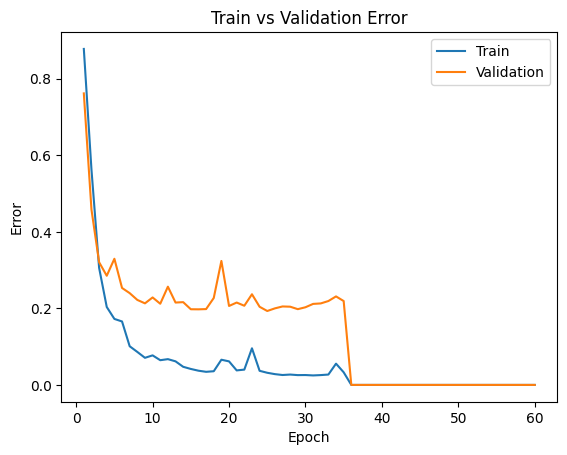

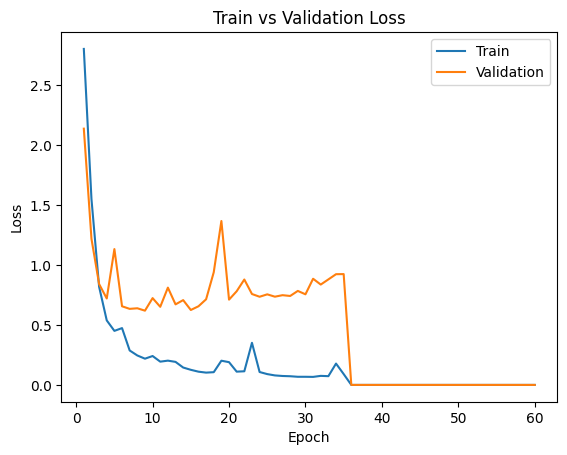

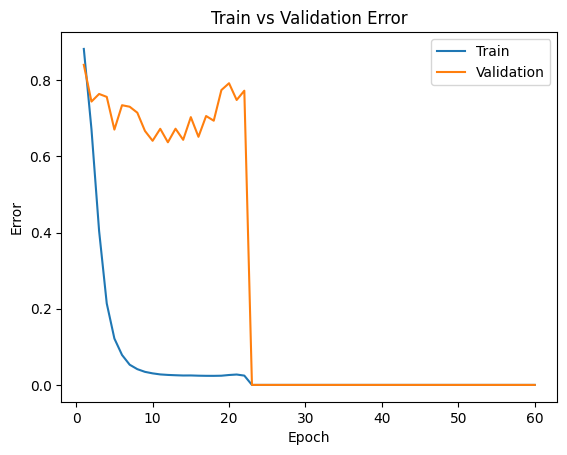

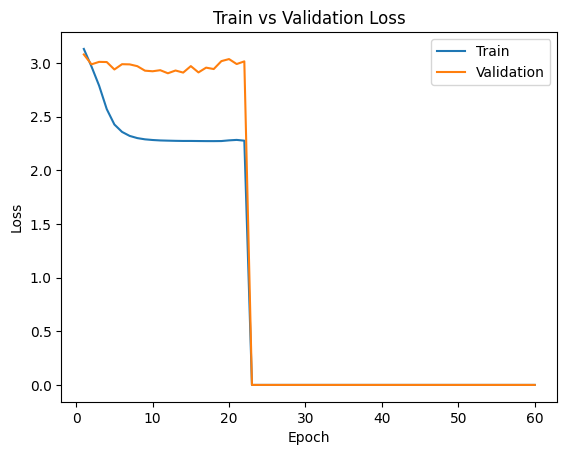

In [11]:
# Graphing
plot_training_curve("baseline_model")
plot_training_curve("primary_model1")

Done Loading Data


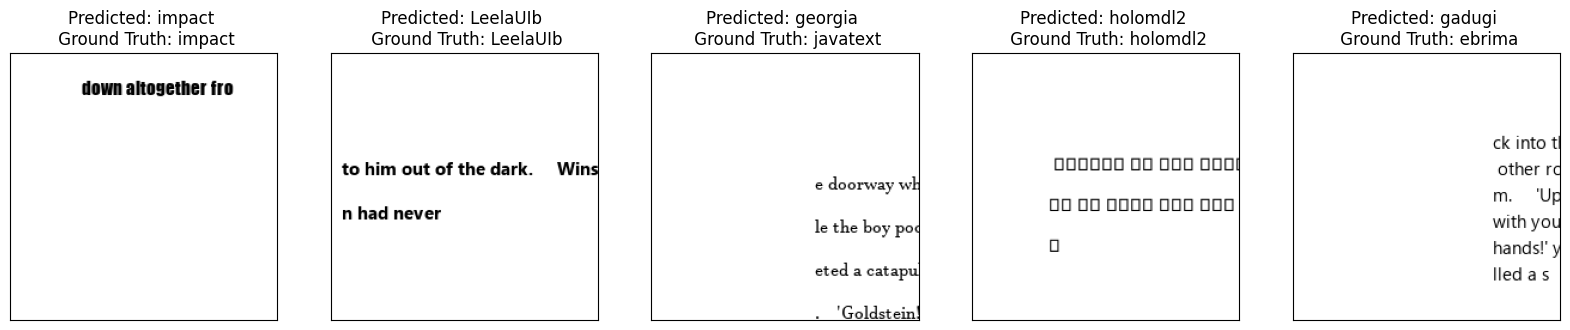

Done Loading Data


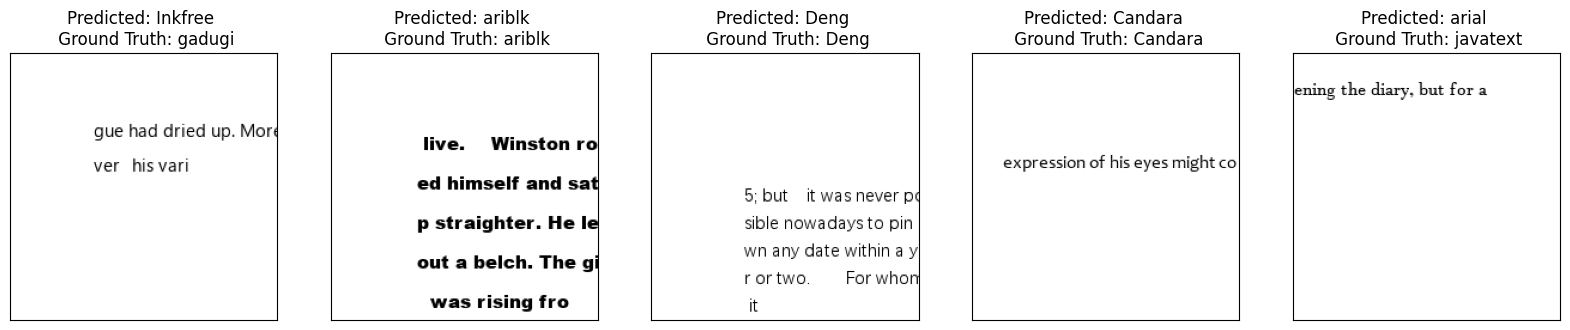

In [12]:
# Visualizing
visualize_output(baseline_model, num_images = 5)
visualize_output(primary_model1, num_images = 5)

Done Loading Data


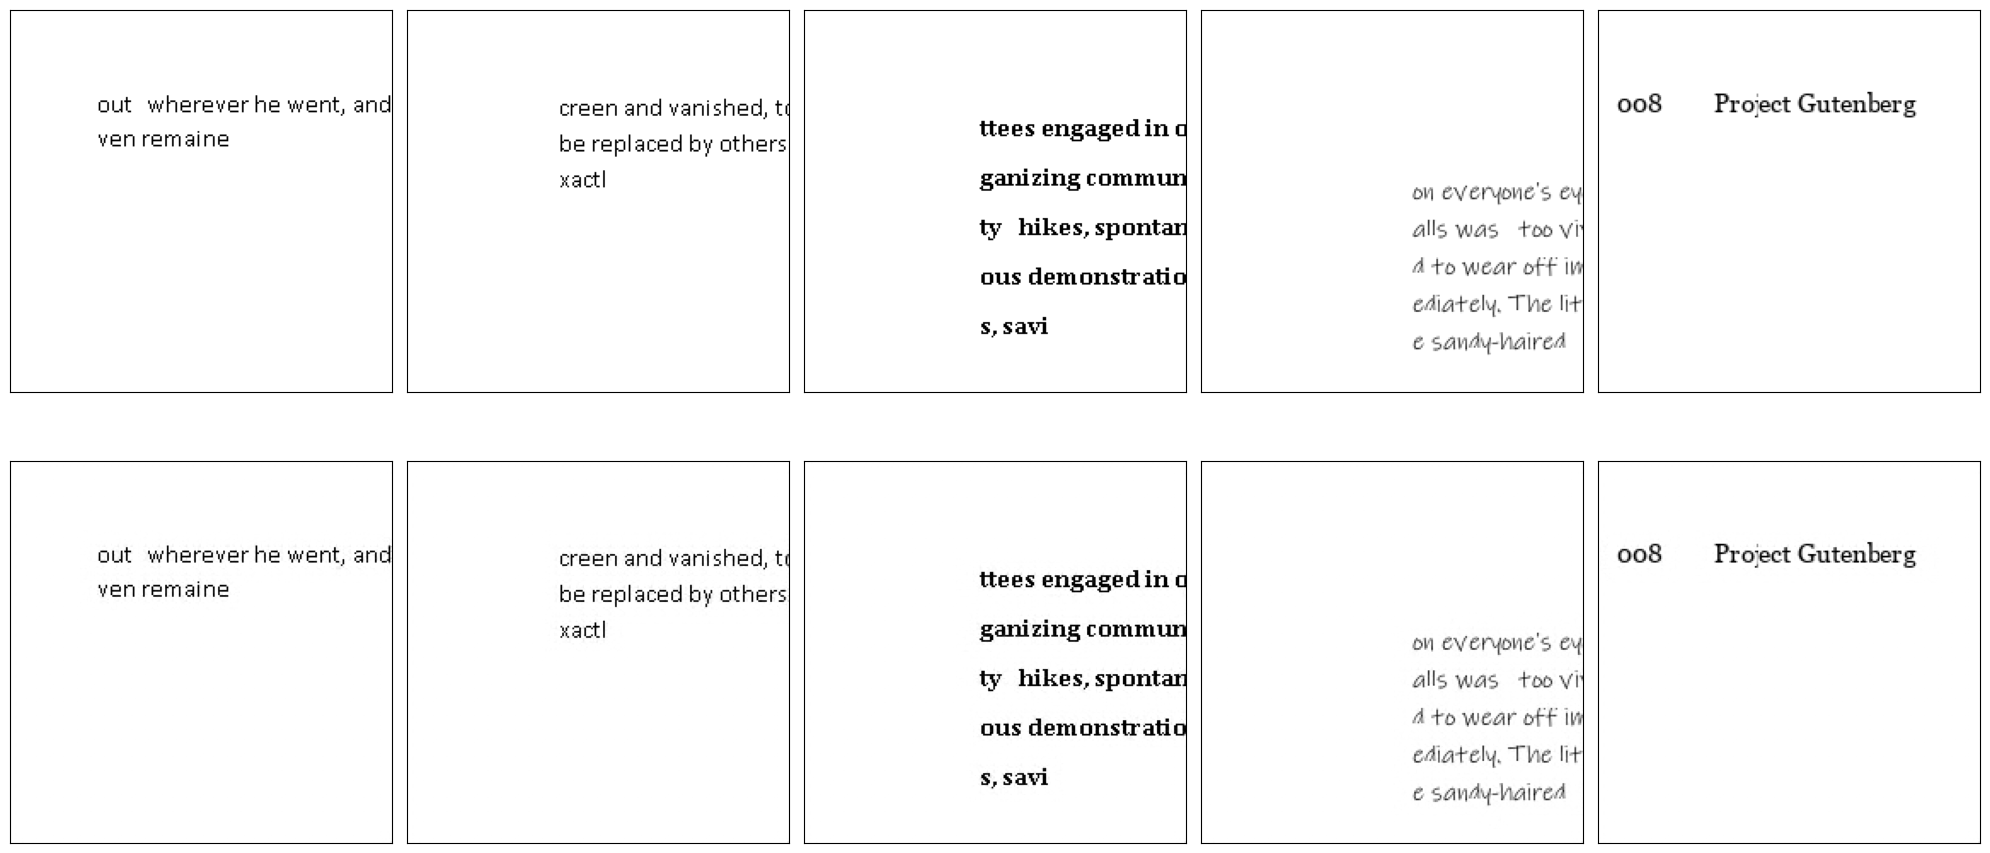

In [13]:
visualize_autoencoder_output(autoencoder, num_images = 5)

Done Loading Data


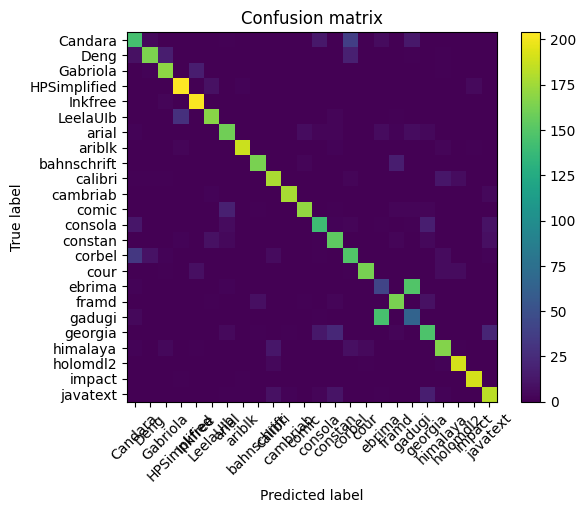

Done Loading Data


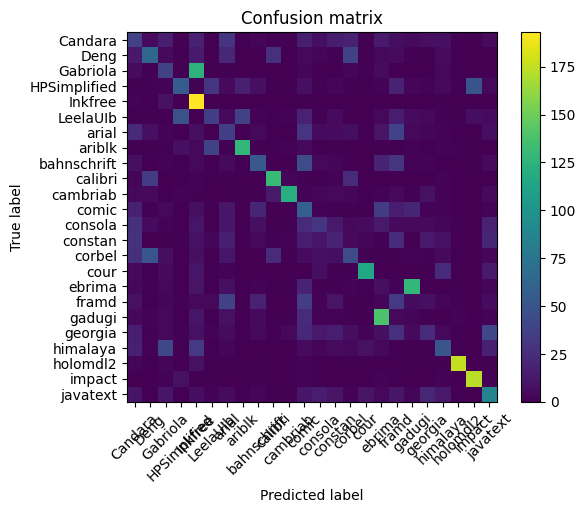

In [14]:
# Confusion Matrix
generate_confusion_matrix(baseline_model)
generate_confusion_matrix(primary_model1)

In [15]:
class PrimaryModel2(nn.Module):
    def __init__(self, encoder, decoder):
        super(PrimaryModel2, self).__init__()
        self.encoder = encoder
        self.encoder.requires_grad_(False)
        self.decoder = decoder
        self.decoder.requires_grad_(False)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) #28x28
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(128, 64, 1) #28x28
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(128, 64, 1)
        self.bn5 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64*28*28, 28*28)
        self.bn6 = nn.BatchNorm1d(28*28)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(28*28, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 24)

    def forward(self, x):
        
        x1 = self.decoder(self.encoder(x))        
        x1 = self.bn1(F.relu(self.conv1(x)))
        x1 = self.bn2(F.relu(self.conv2(x1)))
        x1 = self.bn3(F.relu(self.conv3(x1)))
        
        x2 = self.encoder(x)
        x2 = self.bn4(F.relu(self.conv4(x2)))
        
        x = torch.cat((x1,x2), dim=1) #128x28x28
        x = self.bn5(F.relu(self.conv5(x))) #64x28x28
                
        x = x.view(-1, 64*28*28)
        x = self.bn6(self.dropout(F.relu(self.fc1(x))))
        x = self.bn7(self.dropout(F.relu(self.fc2(x))))
        x = F.softmax(self.fc3(x), dim=1)

        return x

In [16]:
primary_model2 = PrimaryModel2(autoencoder.encoder, autoencoder.decoder)
primary_model2 = primary_model2.to(device)
train_net(primary_model2, "primary_model2", learning_rate = 0.0001, BATCH_SIZE = 32, patience = 10)

Done Loading Data
Starting Training
Epoch 1: Train err: 0.9352083333333333, Train loss: 3.171432688501146 | Validation err: 0.8964583333333334, Validation loss: 3.1548777039845786
Epoch 2: Train err: 0.8730555555555556, Train loss: 3.137906453874376 | Validation err: 0.8604166666666667, Validation loss: 3.11093550046285
Epoch 3: Train err: 0.8308333333333333, Train loss: 3.087235281202528 | Validation err: 0.8210416666666667, Validation loss: 3.066502208709717
Epoch 4: Train err: 0.7811111111111111, Train loss: 3.041222169664171 | Validation err: 0.775, Validation loss: 3.0227704938252766
Epoch 5: Train err: 0.7349305555555555, Train loss: 2.997837267981635 | Validation err: 0.75875, Validation loss: 2.998204469680786
Epoch 6: Train err: 0.70625, Train loss: 2.9651750898361207 | Validation err: 0.723125, Validation loss: 2.965250161488851
Epoch 7: Train err: 0.6677777777777778, Train loss: 2.934124346839057 | Validation err: 0.713125, Validation loss: 2.9666191228230794
Epoch 8: Train 

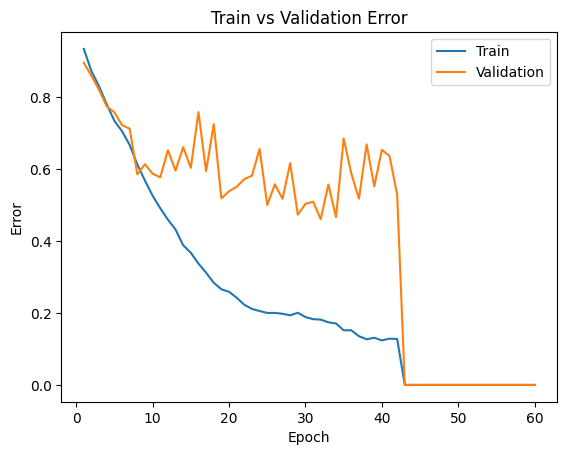

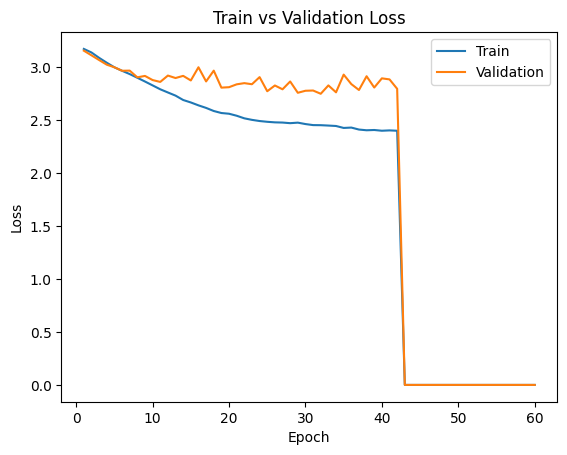

Done Loading Data


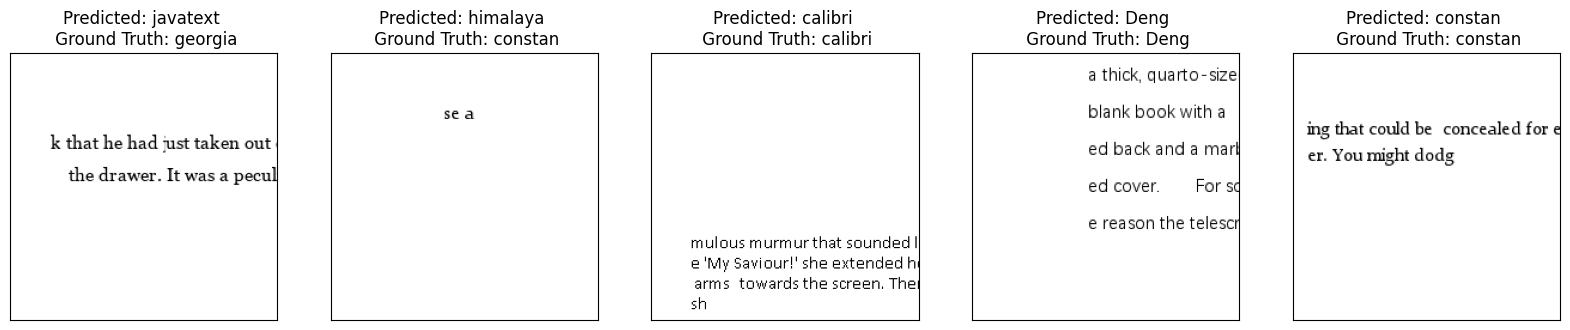

Done Loading Data


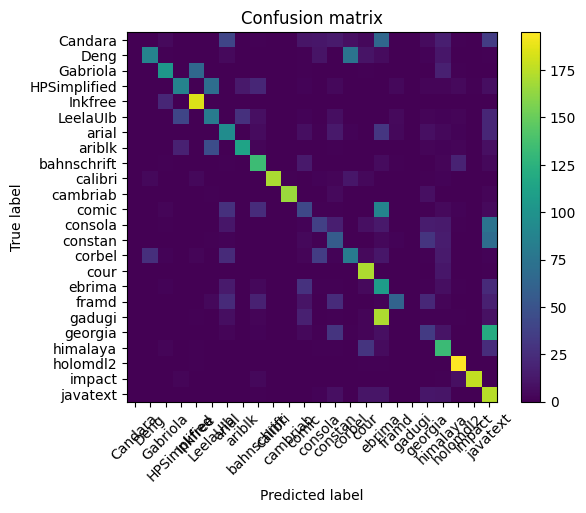

In [17]:
plot_training_curve("primary_model2")
visualize_output(primary_model2, num_images = 5)
generate_confusion_matrix(primary_model2)